In [1]:
import numpy as np
import scipy.optimize as optimize
import scipy as sc
import math as math
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
# Main 
"""
@ Params:
    R: a list of stock price
    k: number of latent components
@ Return:
    price_tplus1
    u_tplus1
    u_smooth
"""
def KalmanFilterForecast(R, k):
    r = 0.25*np.log(np.var(R,axis = 0,ddof=1))
    if k == 1:
        param0 = np.append(np.append(np.append(np.array(100),r,),100),r)
        
    if k == 2:
        param0 = np.append(np.append(np.append(np.array([100,100]),4*r),[-100,-100]),[r,r])
    def objective(params):
        Likelihood,_ = KalmanFilter(R,k,params)
        return Likelihood
    params_star = optimize.fmin(objective,param0)
    print(params_star)
    #params_star = optimize.minimize(objective,param0,method='CG')
    #params_star = params_star.values()[5]
    #print(params_star)
    u_smooth = KalmanSmoother(R, k, params_star)
#     Z = np.array(params_star[0])
#     H = np.exp(params_star[1]);
#     T = np.array(params_star[2])
#     Q = np.exp(params_star[3]);
    Z = 2/(1+np.exp(-params_star[0]))-1;
    H = np.exp(params_star[1]);
    T = 2/(1+np.exp(-params_star[2]))-1;
    Q = np.exp(params_star[3]);
      
    u_tplus1 = T*u_smooth[-1] + np.random.normal()*np.sqrt(Q)
    price_tplus1 = Z*u_tplus1 + np.random.normal()*np.sqrt(H)
    print('T*u_smooth[-1] is {}; Z*u_tplus1 is {}'.format(T*u_smooth[-1],Z*u_tplus1))
    return price_tplus1,u_tplus1,u_smooth,params_star

In [47]:
def KalmanFilter(R,k,params):
    S_length = R.shape[0]
    S = S_length+1
    if k == 1:
#         Z = np.array(params[0])
#         H = np.array(np.exp(params[1]))
#         T = np.array(params[2])
#         Q = np.array(np.exp(params[3]))
        Z = np.array(2/(1+np.exp(-params[0]))-1)
        H = np.array(np.exp(params[1]))
        T = np.array(2/(1+np.exp(-params[2]))-1)
        Q = np.array(np.exp(params[3]))
    if k == 2:
        Z = np.array([[2/(1+np.exp(-params[0]))-1,2/(1+np.exp(-params[1]))-1]])
        H = np.array(np.exp(params[2]))
        T = np.array([[2/(1+np.exp(-params[3]))-1,0],[0,2/(1+np.exp(-params[4]))-1]])
        Q = np.array([[np.exp(params[5]),0],[0,np.exp(params[6])]])
    u_predict = np.zeros((k,S));
    u_update = np.zeros((k,S));
    P_predict = np.zeros((k,k,S));
    P_update = np.zeros((k,k,S));
    v = np.zeros((1,S));
    F = np.zeros((1,S));
    KF_Dens = np.zeros((1,S));
    for i in range(S):
        if i == 0:
            P_update[:,:,i] = 1000*np.eye(k)
            P_predict[:,:,i] = T.dot(np.array(P_update[0][0][0]).dot(T.T))+Q
        else:
            F[0][i] = Z.dot(P_predict[:,:,i-1].dot(Z.T))+H
            v[0][i] = R.T.flatten()[i-1]-Z.dot(u_predict[:,i-1])
            u_update[:,i] = u_predict[:,i-1]+P_predict[:,:,i-1].dot(Z.T.dot(np.linalg.inv([[F[0][i]]]).dot(v[0][i]))).flatten()
            u_predict[:,i] = T.dot(u_update[:,i])
            P_update[:,:,i] = P_predict[:,:,i-1]-P_predict[:,:,i-1].dot(Z.T.dot(np.linalg.inv([[F[0][i]]]).dot(Z.dot(P_predict[:,:,i-1]))))
            P_predict[:,:,i] = T.dot(P_update[:,:,i]).dot(T.T)+Q
            KF_Dens[0][i] = (1.0/2)*np.log(2*np.pi)+(1.0/2)*np.log(np.abs(F[0][i]))+(1.0/2)+v[0][i].T*np.linalg.inv([[F[0][i]]])*v[0][i]
    Likelihood = np.sum(KF_Dens)-KF_Dens[0][0]
    varargout = [u_update, P_update, P_predict, T]
    return Likelihood, varargout

In [48]:
def KalmanSmoother(R,k,params_star):
    _,vararg = KalmanFilter(R,k,params_star)
    u_update = vararg[0]
    P_update = vararg[1]
    P_predict = vararg[2]
    T = np.array(vararg[3])
    S = R.shape[0]+1
    u_smooth = np.zeros((k,S))
    P_smooth = np.zeros((k,k,S))
    u_smooth[:,S-1] = u_update[:,S-1]
    P_smooth[:,:,S-1] = P_update[:,:,S-1]    
    for t in reversed(range(1,S)): # 2 to S inverse sequence
        u_smooth[:,t-1] = u_update[:,t] + P_update[:,:,t].dot(T.T.dot(np.linalg.inv(P_predict[:,:,t]).dot((u_smooth[:,t]-T.dot(u_update[:,t])))))
        P_smooth[:,:,t-1] = P_update[:,:,t] + P_update[:,:,t].dot(T.T).dot(np.linalg.inv(P_predict[:,:,t])).dot((P_smooth[:,:,t]-P_predict[:,:,t])).dot(np.linalg.inv(P_predict[:,:,t])).dot(T).dot(P_update[:,:,t])
    u_smooth = u_smooth.flatten()[1:]
    return u_smooth

In [49]:
data = pd.read_csv('Combined.csv')
data=data.dropna()
R=data["DHHNGSP"].values
#R=np.matrix(R)
k=1
R

array([ 3.41,  3.42,  3.42,  3.38,  3.14,  3.21,  3.27,  3.36,  3.36,
        3.36,  3.37,  3.26,  3.25,  3.23,  3.16,  3.16,  3.26,  3.44,
        3.31,  3.22,  3.  ,  3.15,  3.13,  3.13,  2.92,  3.03,  3.05,
        3.11,  3.11,  2.93,  2.85,  2.95,  2.88,  2.75,  2.75,  2.56,
        2.52,  2.63,  2.63,  2.44,  2.54,  2.54,  2.59,  2.5 ,  2.68,
        2.68,  2.59,  2.83,  2.98,  3.04,  3.02,  3.02,  2.84,  2.85,
        2.93,  3.09,  3.02,  2.93,  2.97,  2.94,  2.95,  3.03,  3.08,
        3.13,  3.13,  3.06,  3.22,  3.23,  3.23,  3.15,  3.11,  2.97,
        3.  ,  3.  ,  3.09,  3.11,  3.11,  3.13,  3.06,  3.06,  2.99,
        3.06,  3.13,  3.2 ,  3.2 ,  3.13,  3.14,  3.11,  3.1 ,  3.06,
        3.03,  3.03,  3.23,  3.24,  3.26,  3.27,  3.27,  3.13,  3.11,
        3.24,  3.22,  3.22,  3.1 ,  3.1 ,  3.1 ,  3.1 ,  3.05,  3.05,
        2.85,  2.92,  2.92,  3.06,  2.98,  3.03,  3.12,  3.12,  2.95,
        2.94,  3.01,  2.87,  2.91,  2.91,  2.88,  2.89,  2.98,  2.99,
        3.03,  3.07,

In [50]:
price_tplus1,u_tplus1,u_smooth,params_star = KalmanFilterForecast(R, k)
#KalmanFilterForecast(R, k)

C:\Users\hehan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


Optimization terminated successfully.
         Current function value: -51.422579
         Iterations: 162
         Function evaluations: 299
[-759.71119367   -7.23085624  120.1391251    -4.39669335]
T*u_smooth[-1] is -2.7475993776696637; Z*u_tplus1 is 2.724166803511561


C:\Users\hehan\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp


In [51]:
print(price_tplus1)

2.74546869073


In [52]:
print(u_tplus1)

-2.72416680351


In [53]:
u_smooth=-u_smooth
print(u_smooth)

[ 3.41936178  3.41734626  3.37017421  3.15580502  3.21037634  3.2713516
  3.35532587  3.3597645   3.36019579  3.36395861  3.26492017  3.24960415
  3.22755228  3.16384967  3.16565358  3.26365975  3.42394069  3.31095391
  3.21419903  3.01873405  3.14205054  3.13009774  3.11980813  2.93609221
  3.0262037   3.05171673  3.10644199  3.10062355  2.93525406  2.85928842
  2.94137599  2.8767161   2.75617689  2.74074463  2.56782154  2.52799088
  2.62413416  2.62046348  2.45451799  2.53561279  2.54205417  2.58344954
  2.51338129  2.67101106  2.67568374  2.60691024  2.82588383  2.97481612
  3.03553871  3.02034729  3.01106549  2.84975275  2.85439424  2.93380884
  3.07803516  3.01866597  2.9365967   2.96677781  2.94212964  2.95371979
  3.02860638  3.07977892  3.12718959  3.12677796  3.07153952  3.21265928
  3.22886827  3.22581954  3.15163553  3.10528194  2.97864506  2.99911374
  3.00450178  3.08649272  3.10880332  3.11075107  3.1254791   3.06327879
  3.05687086  2.99721706  3.0603698   3.12981518  3.

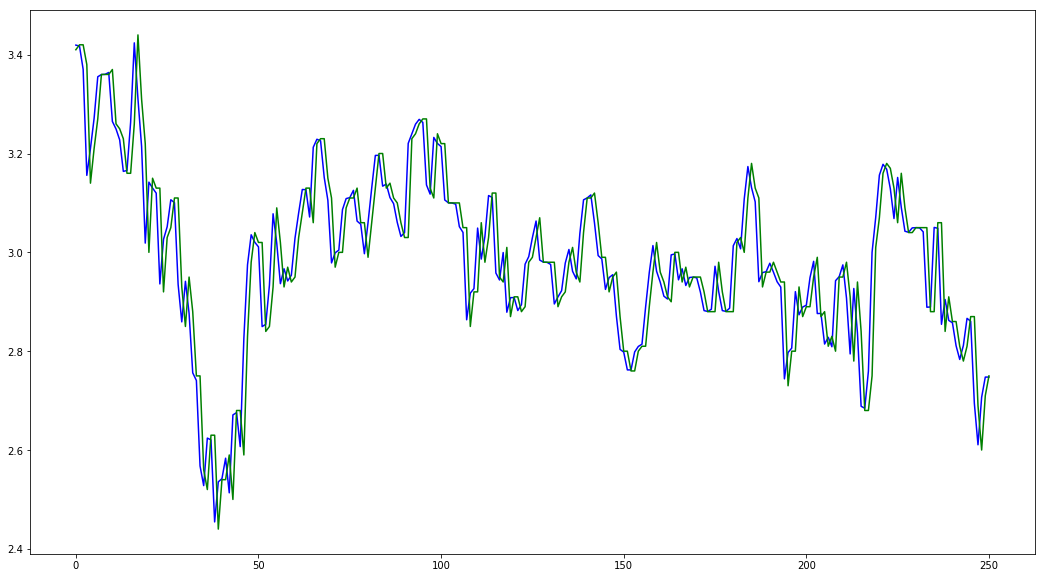

In [57]:
fig = plt.figure(figsize=(18,10))
#plt.plot(price_tplus1,'y',label = "price_tplus1")
#plt.plot(u_tplus1,'r',label = "u_tplus1")
plt.plot(u_smooth,'b',label = "u_smooth")
plt.plot(R,'g',label = "price")
plt.show()


In [3]:
params=np.matrix([[2.34],[3.24],[5.12],[6.34]])

In [97]:
KalmanFilter(R, k, params)

(5444.6111957984631,
 [array([[ 0.        ,  4.52421214,  4.61618517, ...,  5.95973087,
           5.95345882,  5.90274531]]),
  array([[[ 1000.        , -1506.48746248,   943.31782095, ...,
             169.61094657,  -696.65377621,   169.61094657]]]),
  array([[[ 1543.1753818 ,  -904.10651684,  1487.83208851, ...,
             732.40088973,  -113.40185504,   732.40088973]]]),
  matrix([[ 0.98811896]])])

In [98]:
params_star = [2.34,3.41,4.12,5.22]

In [118]:
u_smooth=KalmanSmoother(R, k, params_star)
u_smooth

array([ -5.42088145e+144,  -6.02850940e+144,  -4.34528466e+144, ...,
        -1.04073747e+001,   0.00000000e+000,   5.98286496e+000])

In [100]:
import matplotlib.pyplot as plt

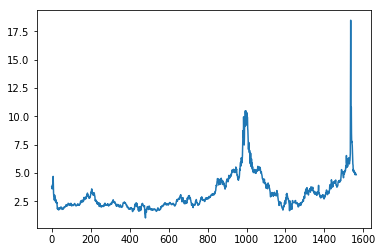

In [104]:
plt.plot(R)
plt.show()

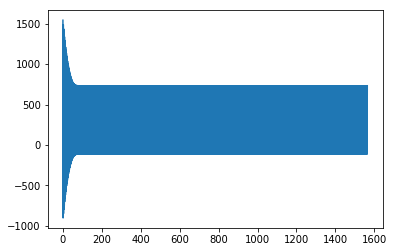

In [117]:
_, varargout = KalmanFilter(R, k, params)
u_update, P_update, P_predict, T = varargout
P_predict = np.squeeze(np.asarray(P_predict))
plt.plot(P_predict)
plt.show()

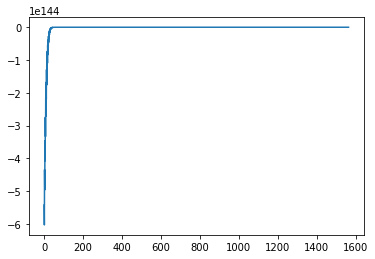

In [119]:
plt.plot(u_smooth)
plt.show()